In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import cv2
import os 
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image
import random
import matplotlib.image as mpimg
from imutils import paths
import sys
import operator

In [3]:
!pip install rich
!pip install hydra-core
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 237 kB 7.8 MB/s 
     |████████████████████████████████| 51 kB 6.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 151 kB 8.9 MB/s 
     |████████████████████████████████| 117 kB 53.2 MB/s 
     |████████████████████████████████| 79 kB 7.2 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=bba22756f8e079eb9215104701032f19c4dab34ebf4d6c3550646bc14563663b
  Stored in directory: /root/.cache/pip/wheels/8b/8d/53/2af8772d9aec614e3fc65e53d4a993ad73c61daa8bbd85a873
Successfully built antlr4-python3-runtime


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 708 kB 7.2 MB/s 
     |████████████████████████████████| 529 kB 51.3 MB/s 


In [4]:
sys.path.insert(0, "/content/drive/MyDrive/Github_Repos/historia_ml_handwritten_text_line_segmentation")
sys.path.insert(1, "/content/drive/MyDrive/Github_Repos/historia_ml_handwritten_text_line_segmentation/src/utils")

In [5]:
import pytorch_lightning as pl
from src.utils.display_image_from_array import img_show_from_arr
from src.utils.delete_border_lines import delete_border_lines
from src.utils.take_pixels_whose_neighbors_are_zero import next_neighbor_as_zero
from src.utils.get_row_heights import get_row_heights
from src.utils.get_col_widths import get_col_widths
from src.utils.erase_short_lines import erase_lines_with_small_width
from src.utils.erase_small_lines import erase_lines_with_small_height
from src.utils.find_image_page_type import find_image_page_type
from src.utils.create_row_patches_from_lines_y_coordinates import create_row_patches
from src.utils.get_unique_cols_from_row_patches import create_unique_patch_cols
from src.utils.create_row_patch_mapping import get_patch_map
from src.utils.create_bboxes import create_bbox_list
from src.utils.create_line_images_from_bbox import create_line_image_from_bbox
from src.utils.create_row_images_from_bbox_list import create_row_images
from src.utils.get_bboxes_from_mask import get_bboxes_from_mask
from src.utils.save_line_images import save_line_images
from src.utils.save_line_images_v2 import save_line_images_v2
from src.utils.display_and_save_line_images import display_and_save_line_images
from src.utils.calculate_the_safety_gaps import calculate_safety_gap_xy
from src.utils.preprocess_img_mask import preprocess_erasing
from src.utils.create_mask_from_coords import create_mask_from_coords
from src.utils.create_coord_pairs import create_pairs_from_unique_coords
from src.utils.get_clean_mask import get_clean_mask
from src.utils.get_left_right_mask_page import get_left_right_mask_pages
from src.utils.create_bboxes_from_pairs import create_bboxes_from_pairs
from src.utils.correct_right_page_bboxes import correct_right_page_bboxes
from src.utils.get_bboxes_from_left_right_mask_pages import get_bboxes_from_left_right_mask_pages
from src.utils.display_line_images import display_line_images
from src.utils.save_left_right_page_sentence_images import save_left_right_line_images
from src.utils.erase_line_startings import erase_line_startings

In [6]:
img_name = "image3-0"
img_path = "/content/drive/MyDrive/Line Extraction/Images/evliya_celebi_1v2/"+img_name+".png"
img = cv2.imread(img_path)
img_mask = cv2.imread("/content/drive/MyDrive/Line Extraction/image masks/evliya_celebi_1v2/"+img_name+".png")
h, w, d = img.shape

In [7]:
cfg = {
    "img_path": img_path,
    "x_ratio": 0.05,
    "y_ratio": 0.08,
    "col_width_limit_ratio": 0.5,
    "row_height_limit_ratio": 0.2,
    "line_gap_ratio": 0.06,
    "safety_gap_x1_ratio": 0.34,
    "safety_gap_x2_ratio": 0.08,
    "safety_gap_y1_ratio": 1.15,
    "safety_gap_y2_ratio": 0.79,
    "safety_erase_ratio_width": 0.01,
    "safety_erase_ratio_height": 0.01,
    "patch_unique_col_size_limit_ratio": 0.5,
    "lower_freq_y_ratio": 0.3,
    "higher_freq_y_ratio": 5,
    "lower_freq_x_ratio":0.1,
    "erase_ratio": 0.1
}

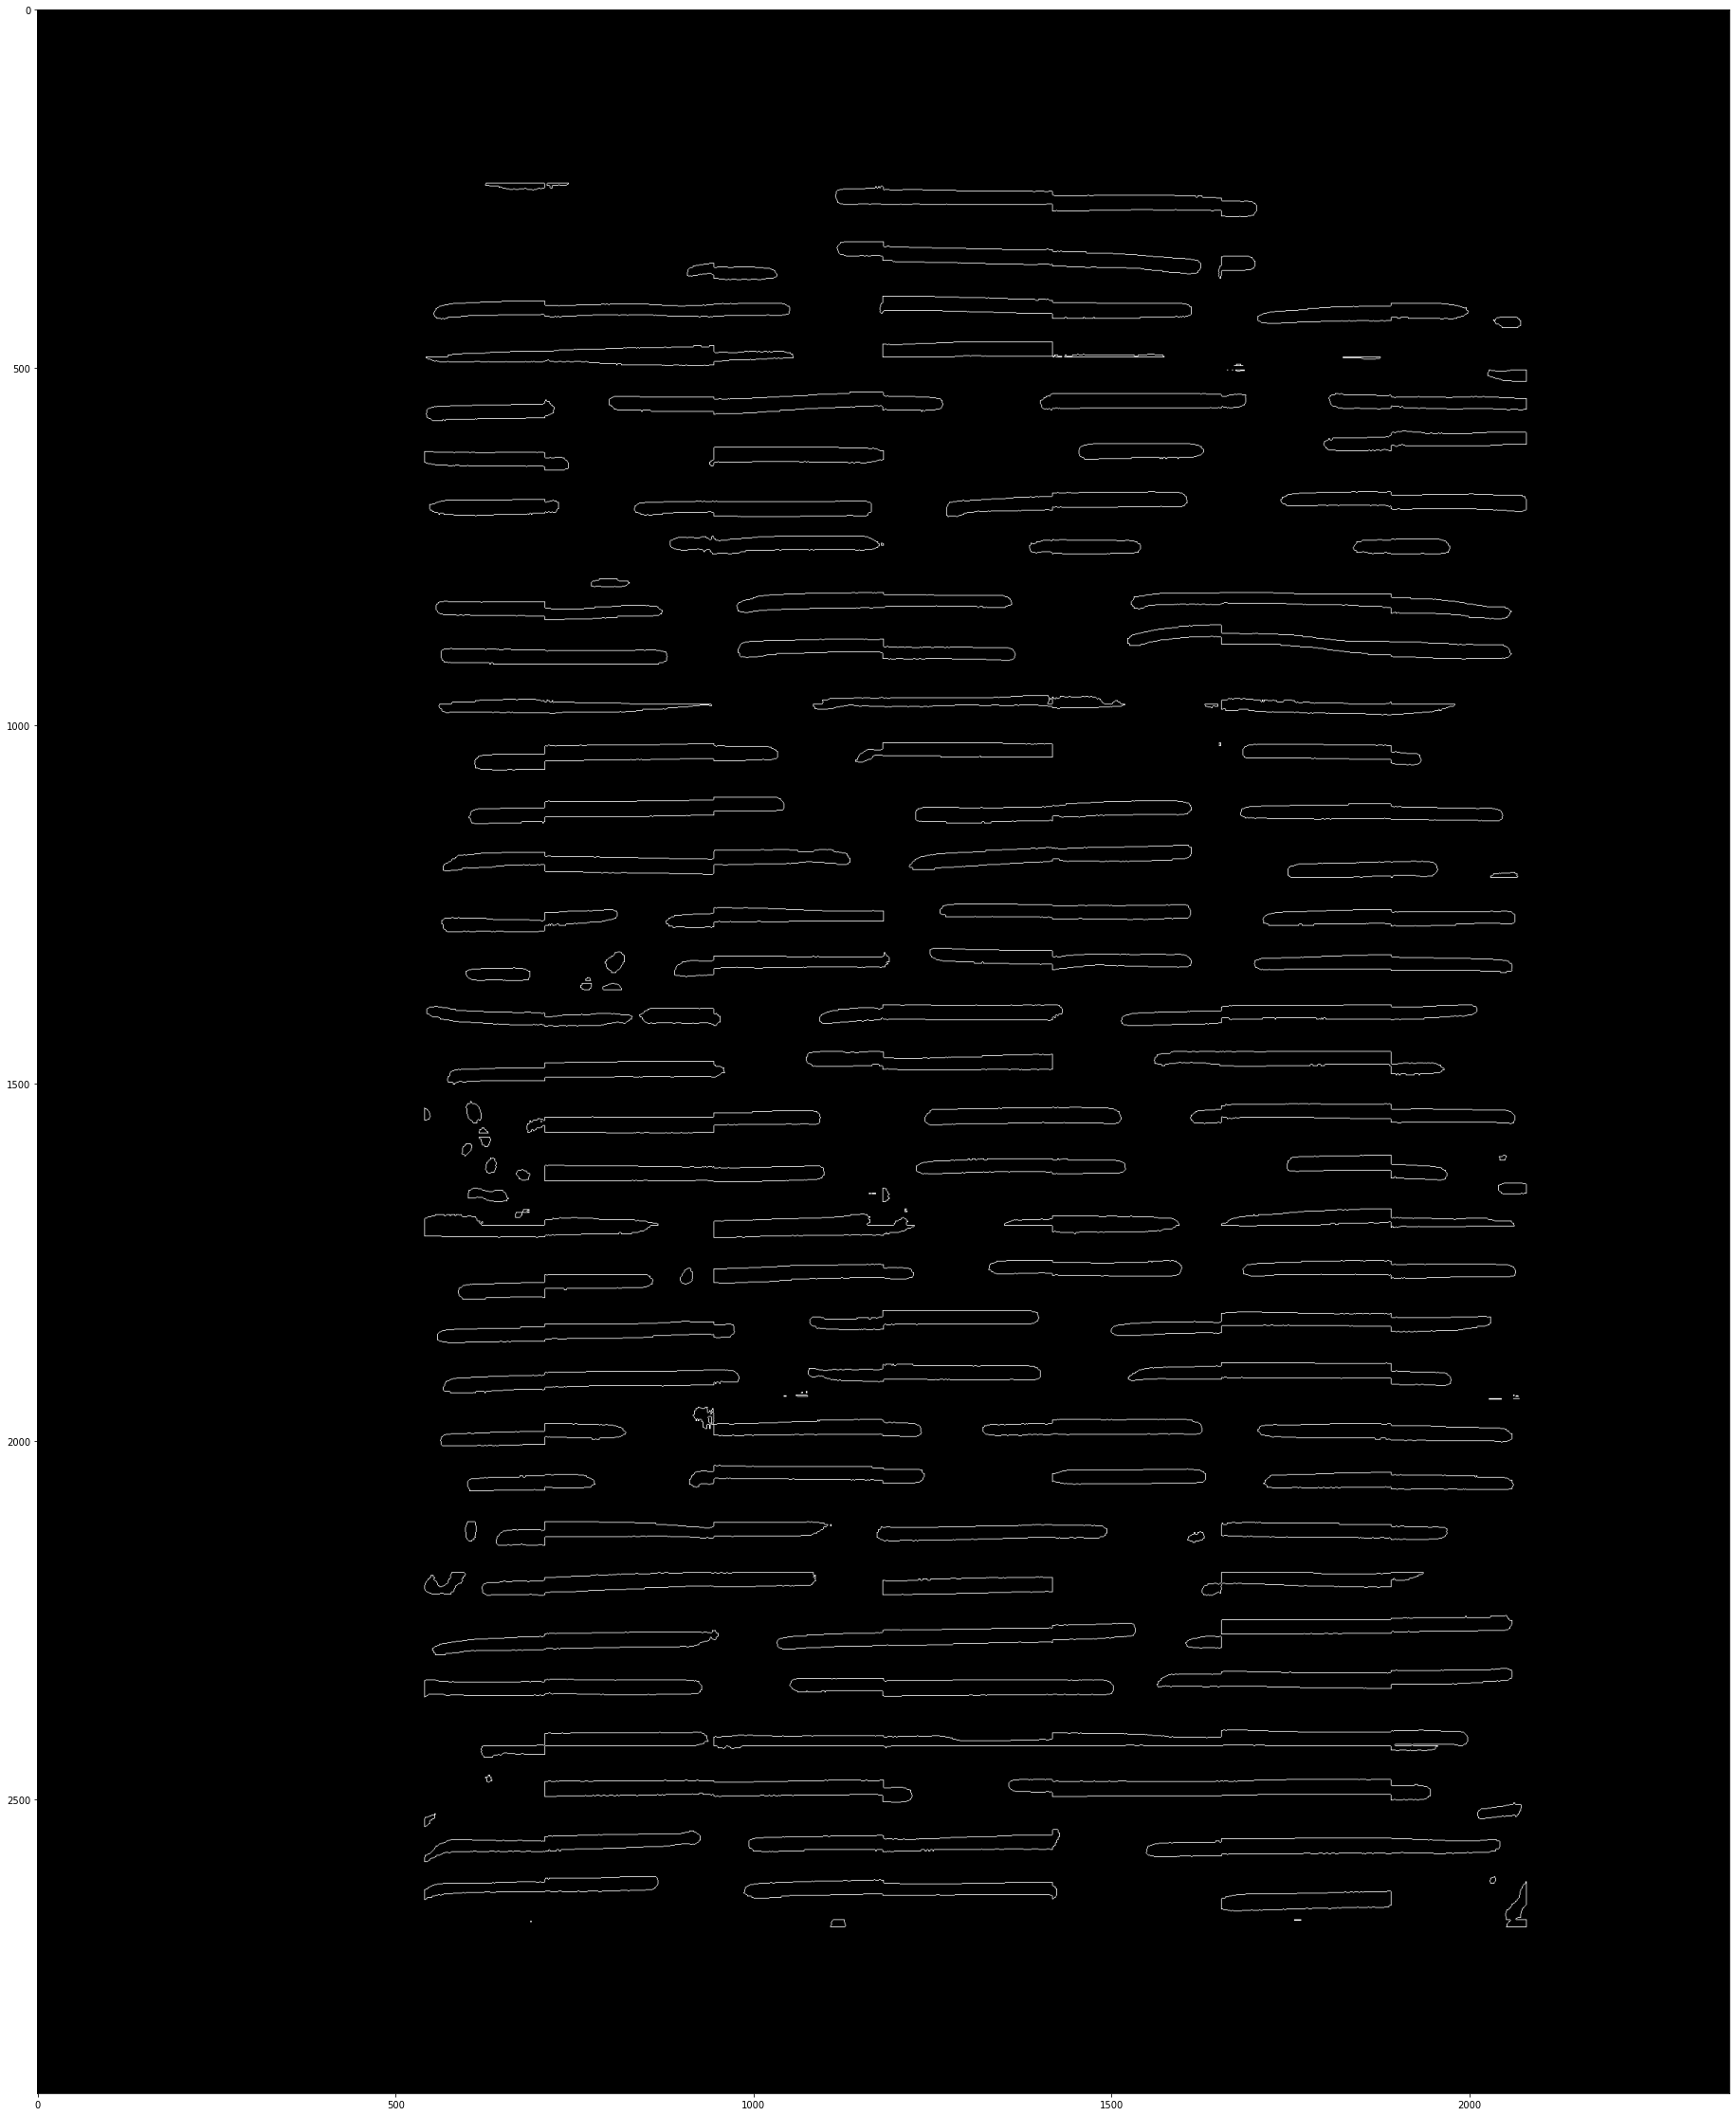

In [8]:
mask = img_mask.copy()
mask = get_clean_mask(mask, cfg["x_ratio"], cfg["y_ratio"], cfg["lower_freq_y_ratio"], cfg["higher_freq_y_ratio"], cfg["lower_freq_x_ratio"], 3,
                      cfg["col_width_limit_ratio"], cfg["row_height_limit_ratio"], cfg["safety_erase_ratio_width"], cfg["safety_erase_ratio_height"])
img_show_from_arr(mask)

In [30]:
white_pixel_coords = []
for i in range(len(mask)):
  for j in range(len(mask[0])):
    if mask[i][j][0] != 0:
      white_pixel_coords.append((i,j))

In [31]:
len(white_pixel_coords)

82181

In [ ]:
white_pixel_coords[:100]

In [33]:
white_pixel_xcoords = []
white_pixel_ycoords = []

for y,x in white_pixel_coords:
  white_pixel_xcoords.append(x)
  white_pixel_ycoords.append(y)

In [39]:
unique_white_pixel_xcoords = np.unique(np.array(white_pixel_xcoords))
unique_white_pixel_ycoords = np.unique(np.array(white_pixel_ycoords))

In [40]:
len(unique_white_pixel_xcoords)

1540

In [53]:
h, w, d = mask.shape
bbox_ypairs = create_pairs_from_unique_coords(unique_white_pixel_ycoords, 3)
bbox_ypairs

[(242, 289),
 (324, 377),
 (400, 444),
 (464, 497),
 (503, 519),
 (534, 574),
 (588, 643),
 (673, 708),
 (735, 760),
 (795, 806),
 (814, 852),
 (859, 914),
 (958, 985),
 (1024, 1062),
 (1100, 1137),
 (1167, 1212),
 (1249, 1288),
 (1311, 1356),
 (1360, 1369),
 (1390, 1420),
 (1455, 1501),
 (1525, 1569),
 (1575, 1665),
 (1675, 1715),
 (1747, 1801),
 (1817, 1862),
 (1890, 1941),
 (1952, 2006),
 (2033, 2069),
 (2112, 2145),
 (2183, 2215),
 (2243, 2298),
 (2317, 2357),
 (2403, 2441),
 (2466, 2538),
 (2542, 2587),
 (2608, 2678)]

In [52]:
len(bbox_ypairs)

35

In [55]:
bbox_xpairs = unique_white_pixel_xcoords[0], unique_white_pixel_xcoords[-1]
bbox_xpairs

(541, 2080)

In [56]:
bboxes = []
for ypair in bbox_ypairs:
  bbox = bbox_xpairs[0], ypair[0], bbox_xpairs[1], ypair[1]
  bboxes.append(bbox)
bboxes

[(541, 242, 2080, 289),
 (541, 324, 2080, 377),
 (541, 400, 2080, 444),
 (541, 464, 2080, 497),
 (541, 503, 2080, 519),
 (541, 534, 2080, 574),
 (541, 588, 2080, 643),
 (541, 673, 2080, 708),
 (541, 735, 2080, 760),
 (541, 795, 2080, 806),
 (541, 814, 2080, 852),
 (541, 859, 2080, 914),
 (541, 958, 2080, 985),
 (541, 1024, 2080, 1062),
 (541, 1100, 2080, 1137),
 (541, 1167, 2080, 1212),
 (541, 1249, 2080, 1288),
 (541, 1311, 2080, 1356),
 (541, 1360, 2080, 1369),
 (541, 1390, 2080, 1420),
 (541, 1455, 2080, 1501),
 (541, 1525, 2080, 1569),
 (541, 1575, 2080, 1665),
 (541, 1675, 2080, 1715),
 (541, 1747, 2080, 1801),
 (541, 1817, 2080, 1862),
 (541, 1890, 2080, 1941),
 (541, 1952, 2080, 2006),
 (541, 2033, 2080, 2069),
 (541, 2112, 2080, 2145),
 (541, 2183, 2080, 2215),
 (541, 2243, 2080, 2298),
 (541, 2317, 2080, 2357),
 (541, 2403, 2080, 2441),
 (541, 2466, 2080, 2538),
 (541, 2542, 2080, 2587),
 (541, 2608, 2080, 2678)]

In [61]:
safety_gap_x1x2y1y2 = calculate_safety_gap_xy(bboxes, cfg["safety_gap_x1_ratio"], cfg["safety_gap_x2_ratio"], cfg["safety_gap_y1_ratio"], cfg["safety_gap_y2_ratio"])

In [64]:
lines = []
for bbox in bboxes:
  line = create_line_image_from_bbox(bbox, img, safety_gap_x1x2y1y2[0], safety_gap_x1x2y1y2[1], safety_gap_x1x2y1y2[2], safety_gap_x1x2y1y2[3])
  lines.append(line)

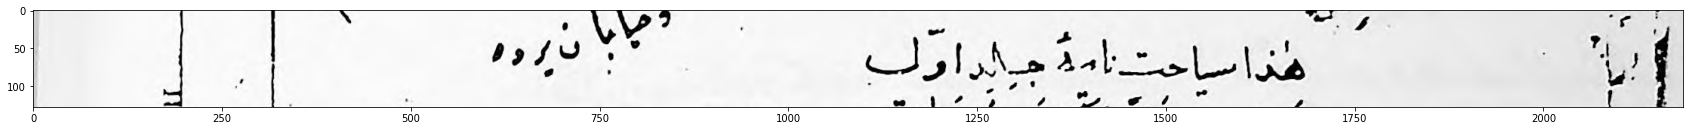

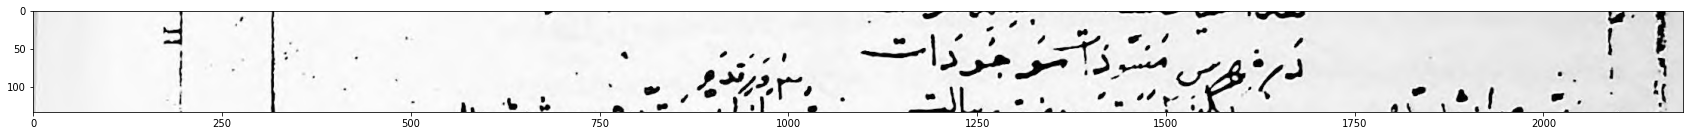

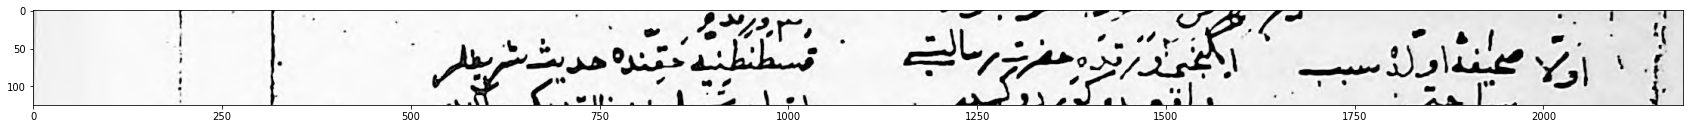

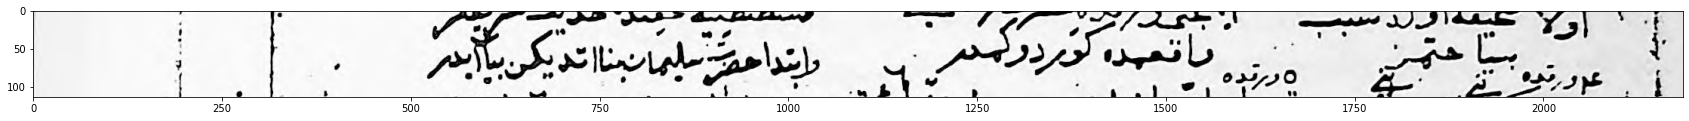

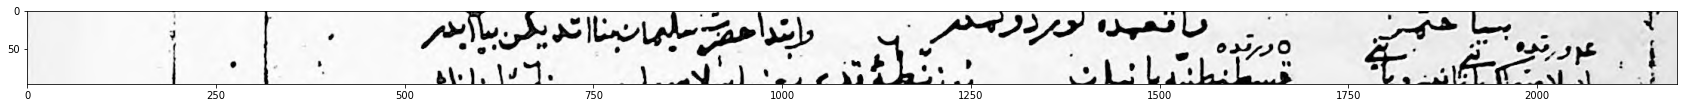

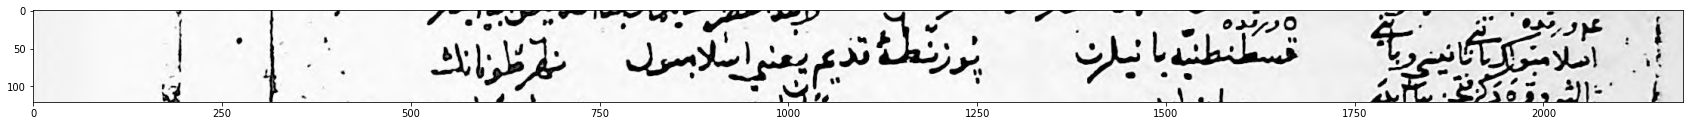

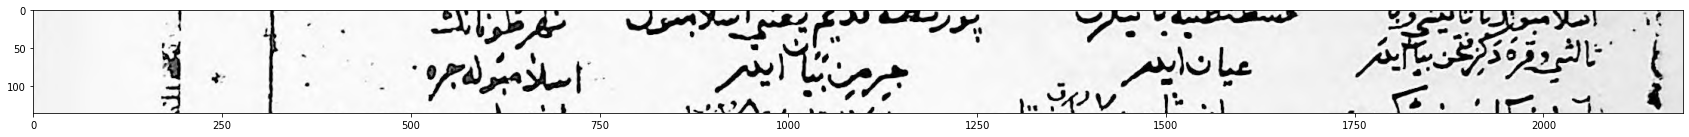

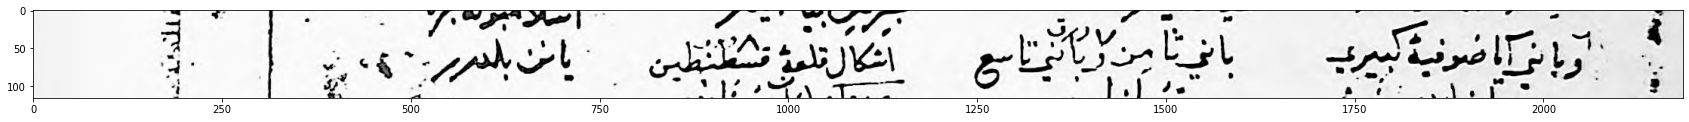

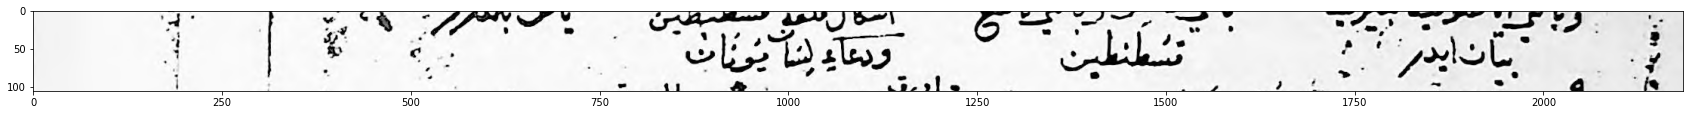

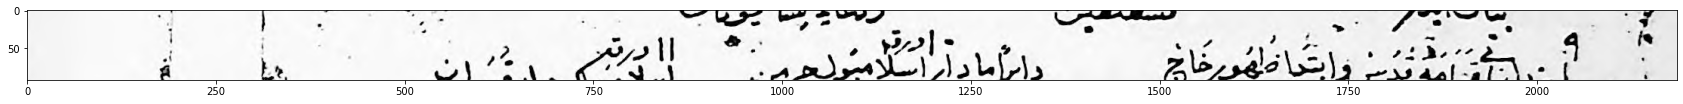

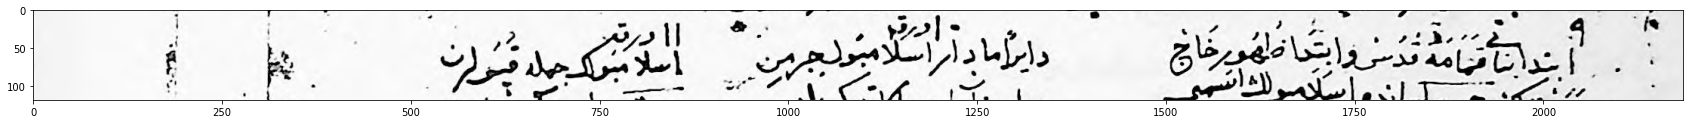

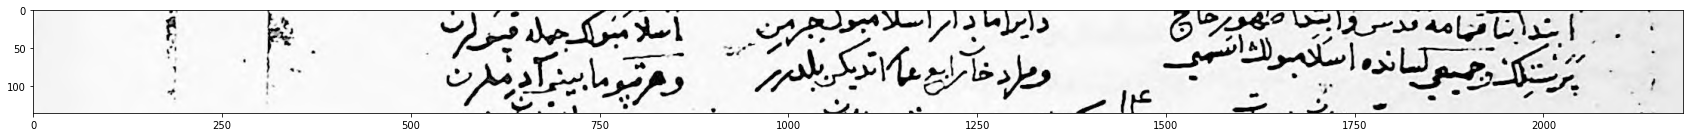

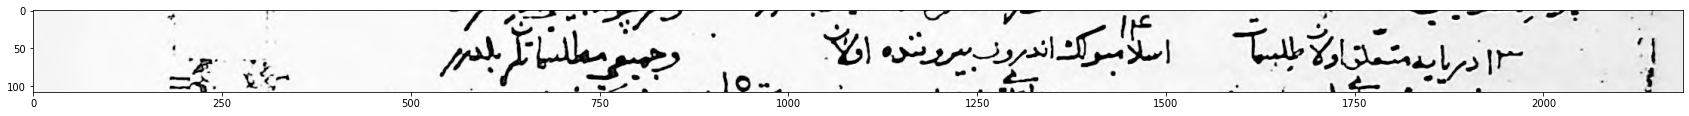

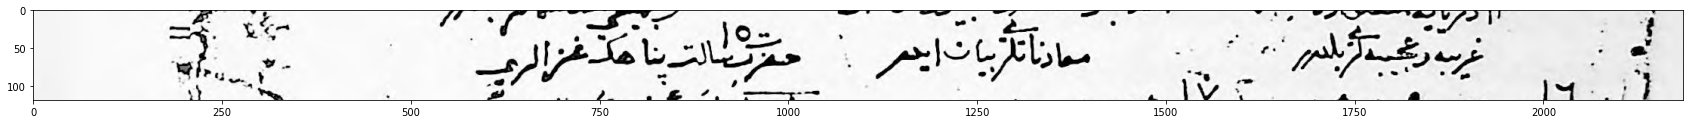

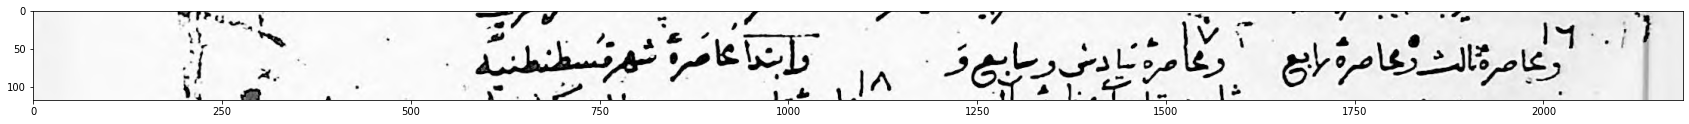

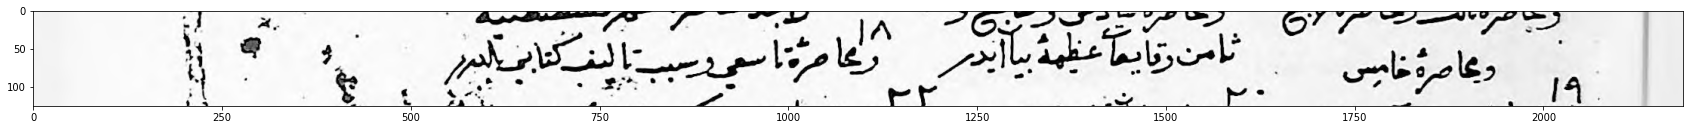

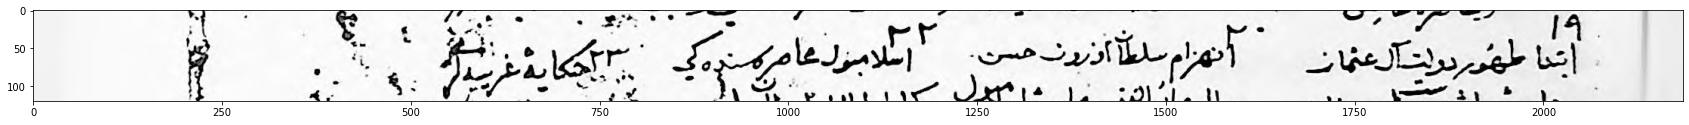

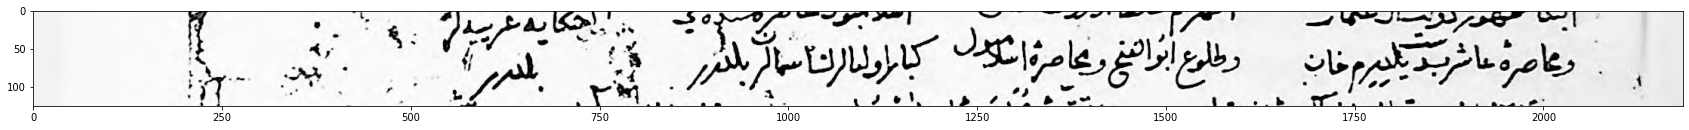

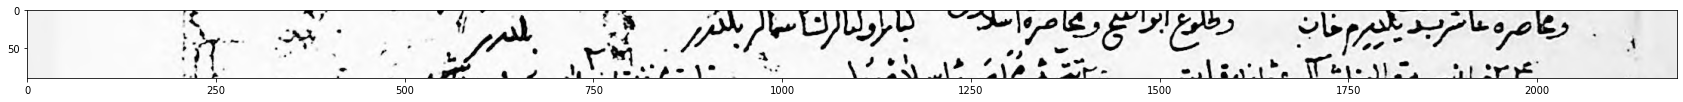

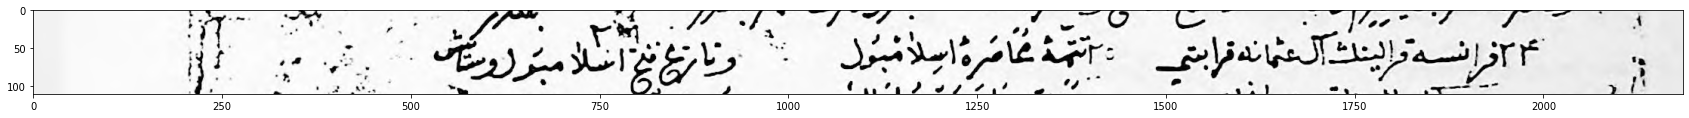

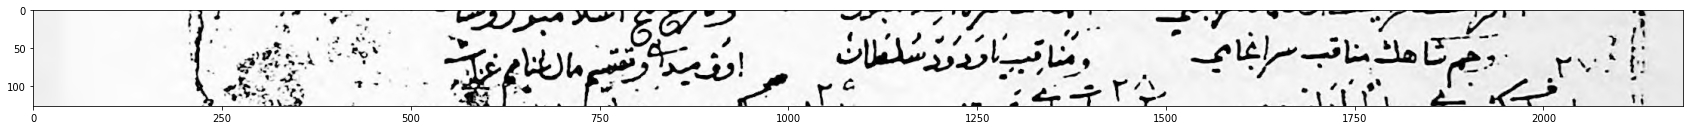

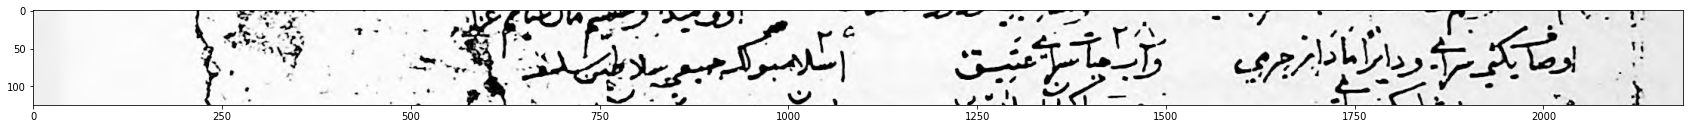

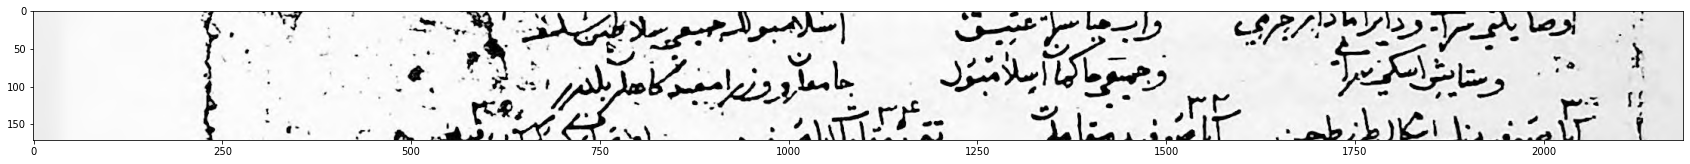

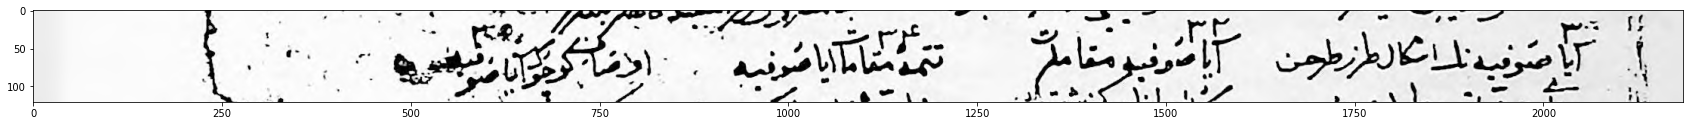

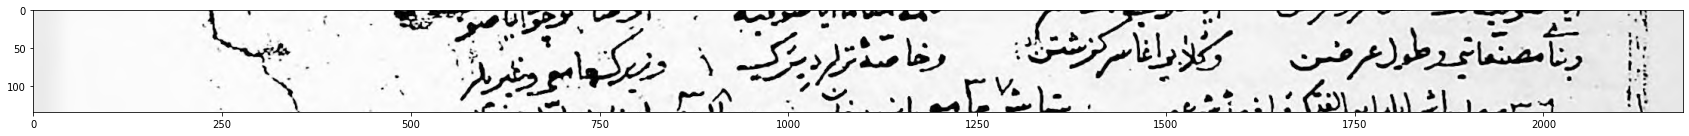

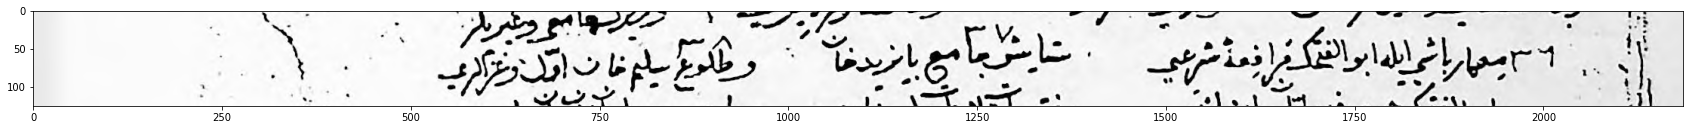

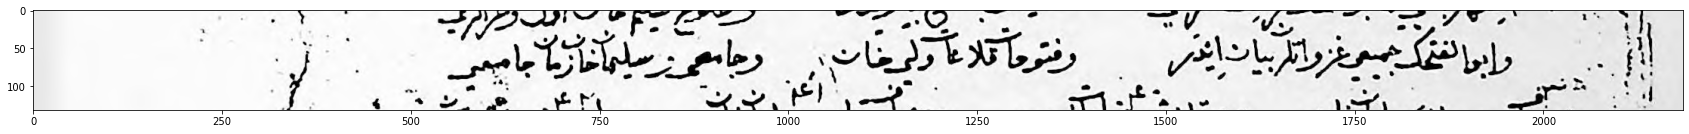

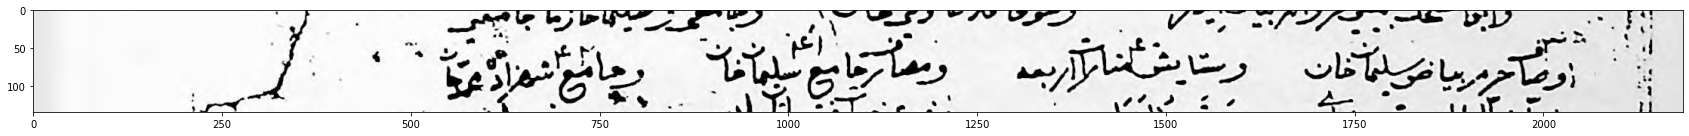

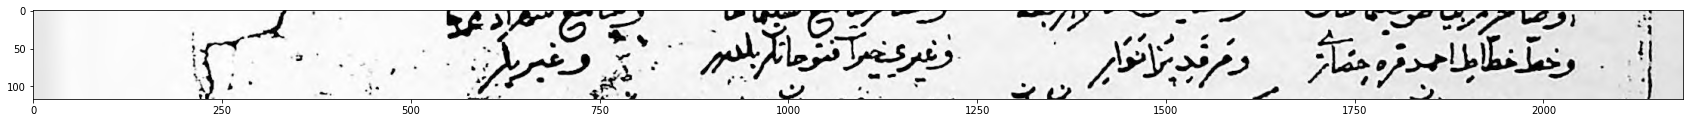

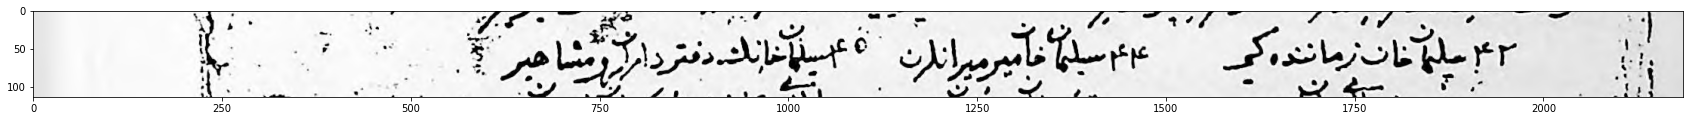

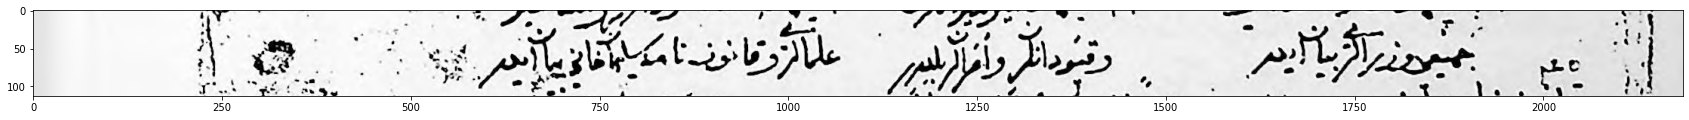

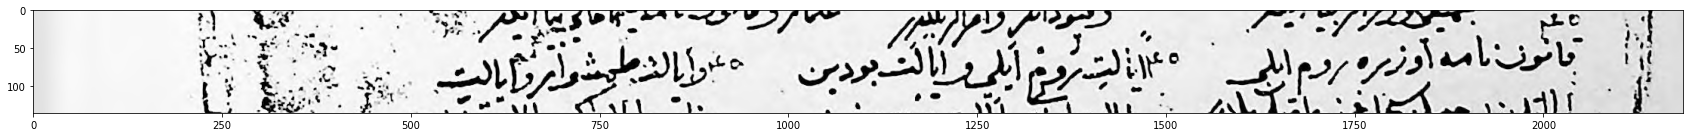

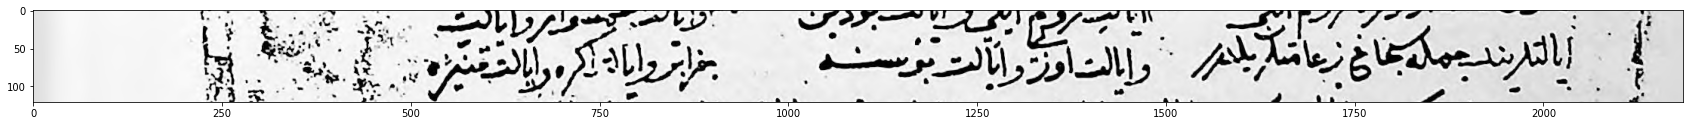

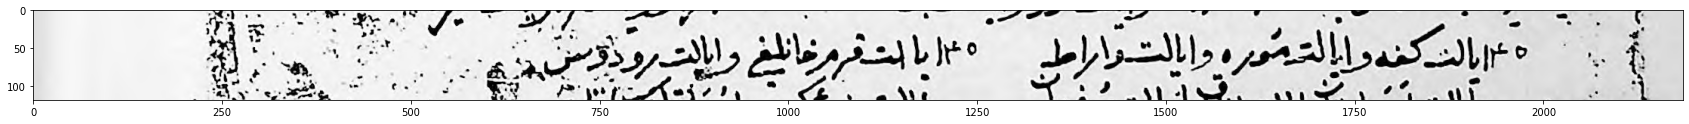

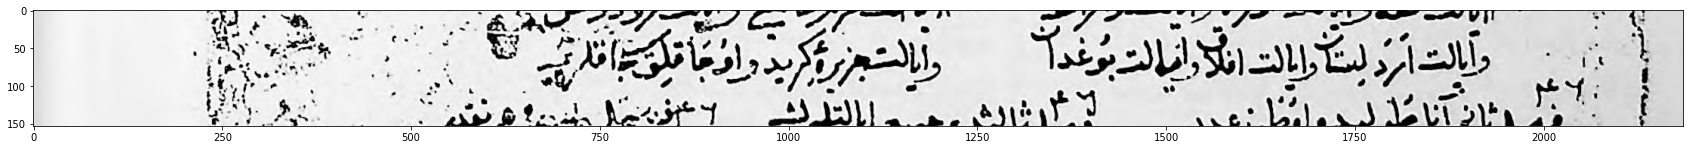

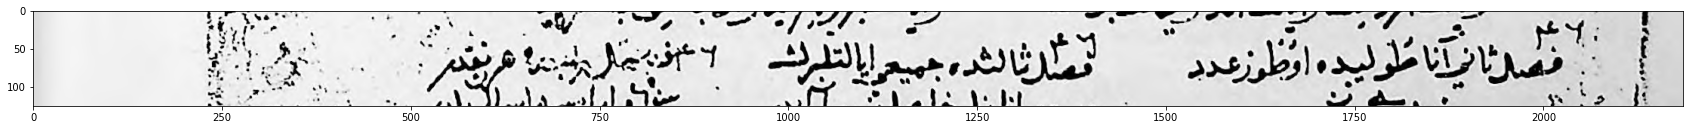

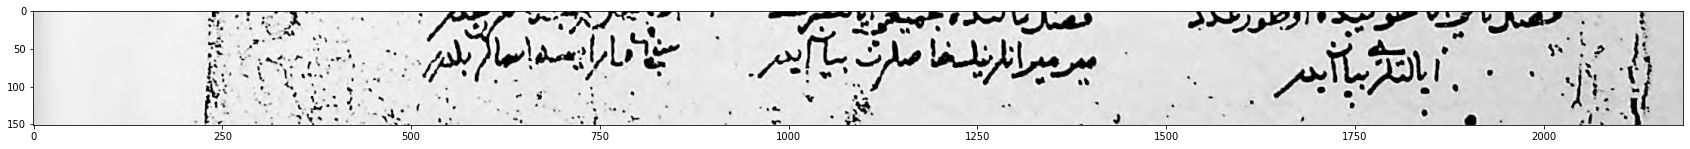

151


In [67]:
for line in lines:
  img_show_from_arr(line)
print(len(line))

In [66]:
filename = img_path.split("/")[-1].split(".")[0]
if not (os.path.exists(filename + " Lines")):
        os.mkdir(filename + " Lines")
for i in range(len(lines)):
      cv2.imwrite(filename + " Lines/" + filename + "_line_" + str(i+1) + ".png", lines[i])